In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
# import talos as ta

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Mumbai'  # to set timezone; needed when running on cloud
time.tzset()

Using TensorFlow backend.


In [0]:
params = {
    "batch_size": 16,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 3
}

iter_changes = "dropout_layers_0.4_0.4"

TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [0]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

  

In [4]:
from google.colab import files
uploaded = files.upload()

Saving raw_fx.csv to raw_fx.csv


In [5]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "raw_fx.csv" with length 613220 bytes


In [6]:
df_fx = pd.read_csv("raw_fx.csv", engine='python')
print(df_fx.shape)
print(df_fx.columns)
display(df_fx.head(5))
tqdm_notebook.pandas('Processing...')
# df_fx = process_dataframe(df_fx)
print(df_fx.dtypes)

(10000, 8)
Index(['date', 'open', 'hi', 'low', 'close', 'avg50', 'avg100', 'avg200'], dtype='object')


,date,open,hi,low,close,avg50,avg100,avg200
0,08/04/1980,8.20,8.20,8.20,8.20,8.0774,8.0680,8.0798
1,09/04/1980,8.20,8.20,8.20,8.20,8.0814,8.0685,8.0814
2,10/04/1980,8.20,8.20,8.20,8.20,8.0854,8.0690,8.0831
3,11/04/1980,8.08,8.08,8.08,8.08,8.0858,8.0683,8.0836
4,14/04/1980,8.08,8.08,8.08,8.08,8.0866,8.0679,8.0843


date       object
open      float64
hi        float64
low       float64
close     float64
avg50     float64
avg100    float64
avg200    float64
dtype: object


In [7]:
print("checking if any null values are present\n", df_fx.isna().sum())

checking if any null values are present
 date      0
open      0
hi        0
low       0
close     0
avg50     0
avg100    0
avg200    0
dtype: int64


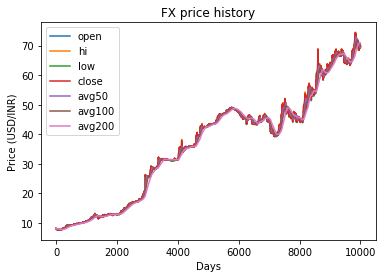

In [8]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_fx["open"])
plt.plot(df_fx["hi"])
plt.plot(df_fx["low"])
plt.plot(df_fx["close"])
plt.plot(df_fx["avg50"])
plt.plot(df_fx["avg100"])
plt.plot(df_fx["avg200"])
plt.title('FX price history')
plt.ylabel('Price (USD/INR)')
plt.xlabel('Days')
plt.legend(['open','hi','low','close','avg50','avg100','avg200'], loc='upper left')
plt.show()

In [9]:
# scale the feature MinMax, build array
train_cols = ["open","hi","low","close"]
x = df_fx.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_tvt = min_max_scaler.fit_transform(x)
print(x_tvt)


[[0.00780429 0.00778414 0.00783413 0.00779523]
 [0.00780429 0.00778414 0.00783413 0.00779523]
 [0.00780429 0.00778414 0.00783413 0.00779523]
 ...
 [0.93250038 0.93254294 0.93512434 0.93278417]
 [0.93261294 0.93095318 0.9332788  0.92961811]
 [0.92880534 0.92989484 0.9312826  0.93066747]]


In [10]:
x_t, y_t = build_timeseries(x_tvt, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

dim_0 9997



length of time-series i/o (9997, 3, 4) (9997,)


In [11]:
batch_size = 16
train_cols = ["open","hi","low","close"]
x_train, x_test = train_test_split(x_t, train_size=0.95, test_size=0.05, shuffle=False)
y_train, y_test = train_test_split(y_t, train_size=0.95, test_size=0.05, shuffle=False)
x_train = trim_dataset(x_train,batch_size)
y_train = trim_dataset(y_train,batch_size)
print("Train--Test size", len(x_train), len(x_test))
print("Train--Test size", len(y_train), len(y_test))
print("length of time-series i/o",x_train.shape,y_train.shape,x_test.shape,y_test.shape)


Train--Test size 9472 500
Train--Test size 9472 500
length of time-series i/o (9472, 3, 4) (9472,) (500, 3, 4) (500,)


In [12]:
x_val, x_test_t = np.split(x_test,2)
y_val, y_test_t = np.split(y_test,2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Test size (250, 3, 4) (250,) (250, 3, 4) (250,)


In [0]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='linear'))
    optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # optimizer = optimizers.RMSprop(lr=0.001)
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [14]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


In [15]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()

Building model...
checking if GPU available ['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)

In [0]:
# Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger('training_log.log',append=True)

In [18]:
history = model.fit(x_train, y_train, epochs = 50, batch_size = BATCH_SIZE,verbose=2,shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)))

Train on 9472 samples, validate on 240 samples
Epoch 1/50
 - 13s - loss: 0.0038 - val_loss: 6.3066e-04
Epoch 2/50
 - 10s - loss: 0.0063 - val_loss: 4.9629e-04
Epoch 3/50
 - 10s - loss: 0.0046 - val_loss: 7.1575e-05
Epoch 4/50
 - 10s - loss: 0.0034 - val_loss: 0.0015
Epoch 5/50
 - 10s - loss: 0.0031 - val_loss: 5.2301e-05
Epoch 6/50
 - 10s - loss: 0.0027 - val_loss: 3.9191e-04
Epoch 7/50
 - 10s - loss: 0.0026 - val_loss: 5.8301e-05
Epoch 8/50
 - 10s - loss: 0.0024 - val_loss: 4.7427e-05
Epoch 9/50
 - 10s - loss: 0.0022 - val_loss: 2.6409e-04
Epoch 10/50
 - 10s - loss: 0.0021 - val_loss: 5.2262e-04
Epoch 11/50
 - 10s - loss: 0.0020 - val_loss: 3.6569e-04
Epoch 12/50
 - 10s - loss: 0.0018 - val_loss: 1.5388e-04
Epoch 13/50
 - 10s - loss: 0.0016 - val_loss: 3.5985e-05
Epoch 14/50
 - 10s - loss: 0.0016 - val_loss: 4.7748e-05
Epoch 15/50
 - 10s - loss: 0.0014 - val_loss: 3.2702e-05
Epoch 16/50
 - 10s - loss: 0.0014 - val_loss: 4.5316e-05
Epoch 17/50
 - 10s - loss: 0.0012 - val_loss: 2.9170e-

In [19]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.000846064965828767 (240,) (240,)
[0.8948704  0.89511824 0.8956381  0.8970103  0.8978008  0.8985778
 0.89887965 0.8963374  0.89395165 0.89330244 0.89402366 0.89231503
 0.8903887  0.889312   0.8882954 ]
[0.90439606 0.90610051 0.90490125 0.91063673 0.90943747 0.90079826
 0.89562643 0.90233482 0.89577634 0.89540157 0.89019226 0.89092381
 0.89150395 0.88815051 0.89122213]


In [20]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[67.374565 67.3911   67.42577  67.51731  67.570045 67.62187  67.642006
 67.47242  67.31328  67.269966 67.31808  67.2041   67.0756   67.00378
 66.93596 ]
[68.01   68.1237 68.0437 68.4263 68.3463 67.77   67.425  67.8725 67.435
 67.41   67.0625 67.1113 67.15   66.9263 67.1312]


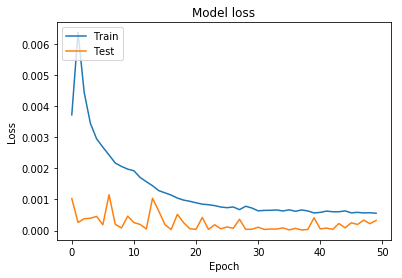

In [0]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

Error is 0.0008808238019418435 (240,) (240,)
[0.88734984 0.88756967 0.8881687  0.8899807  0.8915249  0.8922775
 0.8923751  0.8893726  0.88629687 0.88475287 0.88538814 0.8849366
 0.8831068  0.88207376 0.8811904 ]
[0.90439606 0.90610051 0.90490125 0.91063673 0.90943747 0.90079826
 0.89562643 0.90233482 0.89577634 0.89540157 0.89019226 0.89092381
 0.89150395 0.88815051 0.89122213]
[66.87289  66.88755  66.927505 67.04838  67.15139  67.2016   67.20811
 67.00782  66.80264  66.699646 66.74203  66.7119   66.58984  66.52093
 66.462006 66.41811  66.234604 66.35451  66.4699   66.43946  66.486725
 66.63022  66.73858  66.83737  66.90898  66.917145 66.79653  66.730255
 66.68588  66.81481  66.96578  67.054726 67.54348  67.49082  67.48043
 67.52042  67.53272  67.57477  67.588806 67.62198  67.65846  67.59879
 67.49802  67.47429  67.52771  67.6143   67.790405 67.8307   67.96786
 67.95739 ]
[68.01   68.1237 68.0437 68.4263 68.3463 67.77   67.425  67.8725 67.435
 67.41   67.0625 67.1113 67.15   66.9263 67

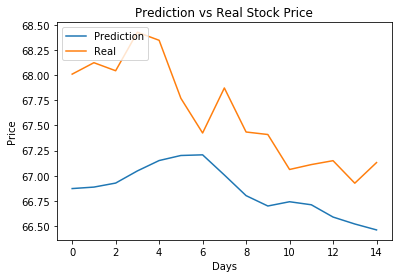

batch_size =  16 timesteps = 3 lr = 0.001 optimizer = Adam No of LSTM layers =2 Dropout=0.4 stateful=True 


In [23]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[00:50])
print(y_test_t_org[00:50])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
#plt.plot(y_pred_org)
#plt.plot(y_test_t_org)
plt.plot(y_pred_org[0:15])
plt.plot(y_test_t_org[0:15])
plt.plot()
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
print("batch_size = ",batch_size ,"timesteps =",TIME_STEPS , "lr = 0.001","optimizer = Adam", "No of LSTM layers =2","Dropout=0.4","stateful=True ")